[*********************100%***********************]  8 of 8 completed


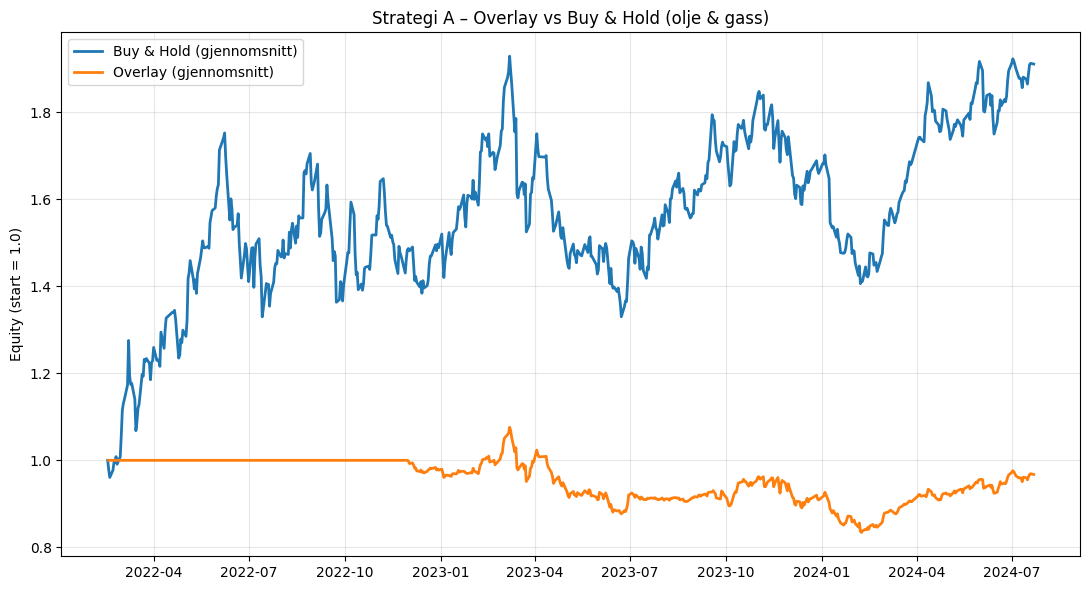

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# --- Olje & gass ---
TICKER = [  "EQNR.OL", "AKRBP.OL", "VAR.OL", "DNO.OL", "SUBC.OL", "TGS.OL","PGS.OL", "BWO.OL"]
start = "2016-01-01"   

k = 3 #inne hvis score >= k
m = 1 #ut hvis score <= m

# --- Data ---
prices = yf.download(TICKER, start=start, auto_adjust=True)["Close"].dropna()

# --- Alignment-score (0–3) ---
dma50  = prices.rolling(50).mean()
dma100 = prices.rolling(100).mean()
dma200 = prices.rolling(200).mean()

score = (
    (dma50 > dma100).astype(int) +      # 1 hvis dma50 > dma100
    (dma100 > dma200).astype(int) +     # 1 hvis dma100 > dma200
    (dma50 > dma200).astype(int)        # 1 hvis dma50 > dma200
)

# --- Overlay posisjoner (inne / ute) ---  
# --- Overlay posisjoner per aksje (inne / ute) ---
pos = pd.DataFrame(0, index=score.index, columns=score.columns)

for ticker in score.columns:
    state = 0
    for date in score.index:
        s = score.loc[date, ticker]

        if state == 0 and s >= k:
            state = 1
        elif state == 1 and s <= m:
            state = 0

        pos.loc[date, ticker] = state

#--- Avkastning ---
returns = prices.pct_change().fillna(0)     #daglig avkastning (prosentvis)

overlay_returns = pos.shift(1) * returns  # Du handler i dag basert på signalet fra i går
benchmark_returns = returns

overlay_equity = (1 + overlay_returns).cumprod()
benchmark_equity = (1 + benchmark_returns).cumprod()

#--- Plot ---
plt.figure(figsize=(11, 6))
plt.plot(benchmark_equity.mean(axis=1), label="Buy & Hold (gjennomsnitt)", linewidth=2)
plt.plot(overlay_equity.mean(axis=1), label="Overlay (gjennomsnitt)", linewidth=2)
plt.title("Strategi A – Overlay vs Buy & Hold (olje & gass)")
plt.ylabel("Equity (start = 1.0)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()